In [56]:
import torch
import numpy
import os
import cv2
import shutil
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

seed = 42

In [2]:
numpy.random.seed(seed)
rng = np.random.default_rng(42)

## SideNote:- ISIC 2018 Dataset has 3 challenges namely as follows

- Task 1 -> Image Binary Segmentation for 2600 images but it does not give any
  Skin diseaces
- Task 2 -> Each image from the above, now have 5 masks which represent skin cancer
  Diagnosis attributes
- Task 3 -> In this task there are 10015 images which were designed for the image classification


## Objective

- Getting mask for the ISIC 2019 dataset which does not provide any binary masks
- Idea: USE SAM 2 and fine tune in the ISIC Task 1


In [3]:
# ISIC 2018 Dataset

# Getting the MetaData Information
csv_path = "/home/nipun/Documents/Uni_Malta/Alive/Dataset/ISIC_2018/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv"


# Train Image Location
train_img_dir = "/home/nipun/Documents/Uni_Malta/Alive/Dataset/ISIC_2018/ISIC2018_Task1-2_Training_Input/"

train_mask_dir = "/home/nipun/Documents/Uni_Malta/Alive/Dataset/ISIC_2018/ISIC2018_Task1_Training_GroundTruth/"

saved_location = "/home/nipun/Documents/Uni_Malta/Alive/Dataset/ISIC_2018/BaseDataset"


# Getting Number of Image in ISIC 2018

num_images = len(os.listdir(train_img_dir))  # 2596

In [4]:
# ISIC 2019 Dataset


IMG_DIR = "/home/nipun/Documents/Uni_Malta/Alive/Dataset/ISIC_2019_Training_Input"

num_imgs = len(os.listdir(IMG_DIR))  # 25333 # 101

In [5]:
num_images

2594

In [6]:
# Find Common images in both datasets

isic_2018 = np.array(os.listdir(train_img_dir))


isic_2019 = np.array(os.listdir(IMG_DIR))


common_images = np.intersect1d(isic_2019, isic_2018)  # 774

In [7]:
# Chose 150 images for the testing
test_images = rng.choice(common_images, 150, replace=False)

train_images = [img for img in isic_2018 if img not in test_images]

In [11]:
def trainValFolder(img_names, img_directory, mask_directory, saved_location, data_type):
    """
    This function copies both image and particular masks based on the training
    and validation split

    """

    for image_name in img_names:
        img_path = os.path.join(img_directory, image_name)
        mask_path = os.path.join(
            mask_directory, image_name.split(".")[0] + "_segmentation" + ".png"
        )

        if not os.path.exists(os.path.join(saved_location, data_type, "imgs")):
            os.makedirs(os.path.join(saved_location, data_type, "imgs"))

        shutil.copy(img_path, os.path.join(saved_location, data_type, "imgs"))

        if not os.path.exists(os.path.join(saved_location, data_type, "masks")):
            os.makedirs(os.path.join(saved_location, data_type, "masks"))

        shutil.copy(mask_path, os.path.join(saved_location, data_type, "masks"))

In [10]:
# trainValFolder(test_images,train_img_dir,train_mask_dir,saved_location,"val")

trainValFolder(train_images, train_img_dir, train_mask_dir, saved_location, "train")

In [ ]:
# Side Note:
# Original Training Size: 2594
# Obtain 150 images from the training set which is common in both ISIC 2018 and ISIC 2019
# Additionaly there's seperate validation set for ISIC 2018 which consist of 100 images

# Adding augmentations


In [23]:
import random

import cv2
from matplotlib import pyplot as plt

import albumentations as A

In [24]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title("Original image", fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title("Original mask", fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title("Transformed image", fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title("Transformed mask", fontsize=fontsize)

In [89]:
image = cv2.imread(
    "/home/nipun/Documents/Uni_Malta/Alive/Dataset/ISIC_2018/BaseDataset/train/imgs/ISIC_0000182.jpg"
)
mask = cv2.imread(
    "/home/nipun/Documents/Uni_Malta/Alive/Dataset/ISIC_2018/BaseDataset/train/masks/ISIC_0000182_segmentation.png",
    cv2.IMREAD_GRAYSCALE,
)

In [90]:
original_height, original_width = image.shape[:2]

In [91]:
print(original_height, original_width)

1051 1502


In [92]:
aug = A.CenterCrop(
    p=1, height=(original_height // 4) * 3, width=(original_width // 4) * 3
)

augmented = aug(image=image, mask=mask)

image_center_cropped = augmented["image"]
mask_center_cropped = augmented["mask"]

print(image_center_cropped.shape, mask_center_cropped.shape)

# assert (image - image_center_cropped).sum() == 0
# assert (mask - mask_center_cropped).sum() == 0

# visualize(image, mask, original_image=image_center_cropped, original_mask=mask_center_cropped)

(786, 1125, 3) (786, 1125)


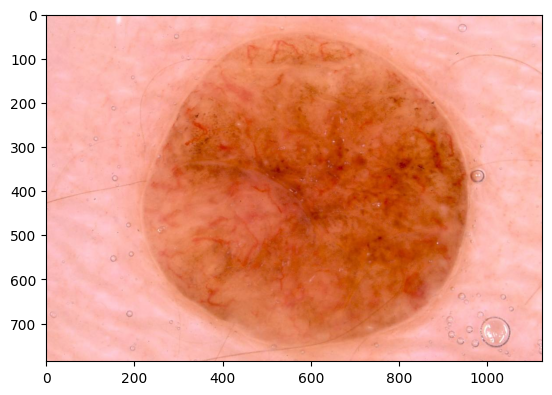

In [93]:
plt.imshow(image_center_cropped[:, :, ::-1])

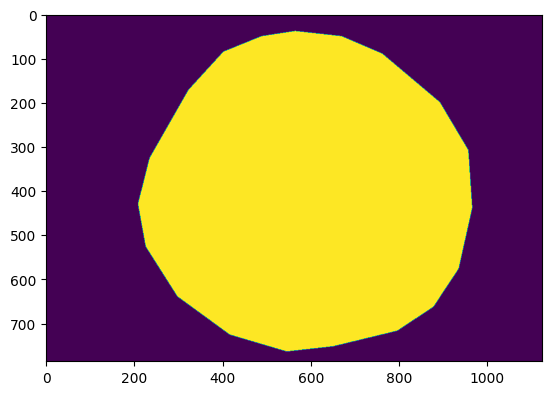

In [94]:
plt.imshow(mask_center_cropped)

# Segment Anything (SAM 2)


In [1]:
IMAGE_SOURCE_DIR = (
    "/home/nipun/Documents/Uni_Malta/Alive/Dataset/ISIC_2018/BaseDataset/"
)

In [42]:
def dataReading(source_path:str):
    """
    Indexing all the ISIC images and masks from Dataset Base Directory
    
    """
    
    data = {}
    for fld in os.scandir(IMAGE_SOURCE_DIR):
        
        folder_type = os.path.basename(fld.path)
        
        data[folder_type] = {"imgs":[],"masks":[]}
        
        for subfld in os.scandir(fld.path):
            
      
            
            if os.path.basename(subfld.path) == "masks":
                
                
                
                data[folder_type]["masks"] = [os.path.join(subfld.path,f ) for f in sorted(os.listdir(subfld.path))]
                
            else:
                
                data[folder_type]["imgs"] = [os.path.join(subfld.path,f ) for f in sorted(os.listdir(subfld.path))]
            
            
       
       
    return data
        
        

In [43]:
dataset = dataReading(IMAGE_SOURCE_DIR)

In [44]:
train_dataset = dataset["train"]
val_dataset = dataset["val"]


In [45]:
idx = random.randint(0,len(val_dataset["imgs"]))
img_sample = "_".join(os.path.basename(val_dataset["imgs"][idx]).split(".")[0].split("_")[:2])
mask_sample =  "_".join(os.path.basename(val_dataset["masks"][idx]).split(".")[0].split("_")[:2])


assert img_sample == mask_sample, "Different Mask and Image for given File Path"


In [238]:
def read_single(data):

    ent = np.random.randint(len(data["imgs"]))

    img = cv2.imread(data["imgs"][ent])[:, :, ::-1]

    ann_map = cv2.imread((data["masks"][ent]),0)

    assert (img.shape[0] == ann_map.shape[0]) and (
        img.shape[1] == ann_map.shape[1]
    ), "Dimension Mismatching of Image and Mask"

    r = np.min([1024 / img.shape[1], 1024 / img.shape[0]]) 
    
    
    img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
    
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)),interpolation=cv2.INTER_NEAREST)
    
    
    if img.shape[0] < 1024:
        img = np.concatenate(
            [img,
            np.zeros([1024-img.shape[0],img.shape[1],3],dtype=np.uint8)
        ],axis=0)
        
        ann_map = np.concatenate(
            [ann_map,
            np.zeros([1024-ann_map.shape[0],ann_map.shape[1]],dtype=np.uint8)
        ],axis=0)
        
        
    if img.shape[1] < 1024:
        img = np.concatenate(
            [img,
            np.zeros([img.shape[0],1024-img.shape[1],3],dtype=np.uint8)
        ],axis=0)
        
        ann_map = np.concatenate(
            [ann_map,
            np.zeros([ann_map.shape[0],1024-ann_map.shape[1]],dtype=np.uint8)
        ],axis=0)


    
    binary_mask  = ann_map/255.0 # By Dataset we get the binary masks
    
    # In order to avoid selecting boudary points
    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)
    
    
   
    coords = np.argwhere(eroded_mask >0.0) # get all foreground locations
    
    
    # Get a random yx coordinate
    yx = np.array(coords[np.random.randint(len(coords))]) 
    
   
    
    return img,binary_mask,list(reversed(yx)) # xy coordinate
    



In [300]:
def visualization(img,mask,points):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    
    ax1.imshow(img)
    ax1.set_axis_off()
    ax1.set_title("Original Image")
    
    ax2.imshow(mask)
    
    ax2.scatter(points[0],points[1])
    ax2.set_axis_off()
    ax2.set_title("Mask with point")
    
    
    
    

In [301]:
img,binary_mask,coordinates = read_single(train_dataset)

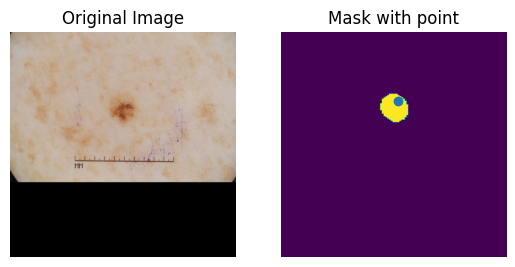

In [302]:
visualization(img,binary_mask,coordinates)